# Marketing Mix Model
<B> Author:</B> Dominick Russo <br>
<B> email: </B> dominick.russo19@gmail.com<br>

Muma College of Business<br>
ISM6905: Integrative Project<br>
Master of Science, Business Analytics and Information Systems<br>
December 6, 2021

# Introduction
Advertisers use marketing mix models, also known as media mix models, to measure the effectiveness of various advertising channels on improving a metric [[1]](#Sources:), such as sales or return on investment (ROI). These models use time series data to model an outcome resulting from advertising variables, usually marketing or media spend [[1]](#Sources:). <Br>

The purpose of this project is to explore building a marketing mix model using simulated weekly marketing and sales data. The model will attempt to predict a change in sales volume based on changes in spend for TV and paid search advertisements.

# Data

The data for this model was generated using the Aggregate Marketing System Simulator (AMASS) [[4]](#Sources:), an open source R package provided by Google, Inc for research purposes. Code was obtained from [Google GitHub](https://github.com/google/amss/blob/master/vignettes/amss-vignette.Rmd) [[2]](#Sources:).

[R Code](https://github.com/deejayrusso/Marketing-Mix-Model/blob/main/Data%20Generation%20-%20AMSS.R)<br>
[Simulated Data](https://github.com/deejayrusso/Marketing-Mix-Model/blob/main/ObservedData.csv)

Variables used:<br>
* <b>tv.spend:</b> Weekly dollar spend on TV advertisement
* <b>search.spend: </b> Weekly dollar spend on paid search advertisement
* <b>revenue: </b> Weekly dolllar sales

The AMASS was used to generate 208 rows representing 4 years of weekly data. The first 52 rows were dropped to allow the simulator time to normalize and produce more consistent data. The next 52 rows were dropped after feature engineering to remove null values produced after shifting data to create lag variables, leaving 104 rows representing 2 years.

# Method

Ordinary least squares regressions, a polynomial regression, and multiple regularized regression models are explored to see which predicts sales based on tv and search advertising spend with the lowest error.

<b>Steps and contents:</b>
1. Generate data and [load](#Load-Data) simulated data.<br>
2. [Explore data](#Explore-Data)
3. [Select features and target variable for models](#Select-features-and-target-variable-for-models)
4. [Feature engineering](#Feature-Engineering): Lag variables and rolling averages for marketing spend.
5. [Prepare data](#Prepare-data-for-pipeline) for model training and testing
6. [Create data pipeline](#Pipeline)
7. [Calculate baseline metrics](#Baseline)
8. Explore regression models
    * [Ordinary least squares](#Linear-Regression)
    * [Polynomial](#Polynomial-Regression)
    * [Lasso ](#Lasso-Regression)
    * [Ridge](#Ridge-Regression)
    * [Elastic net](#Elastic-Net)
    * [Stochastic gradient](#Stochastic-Gradient-Regressor)
9. [Compare models](#Model-Comparison) and [select best model](#Best-Model)
10. [Interpret findings](#Interpretation)

# Load Data

In [ ]:
# Common imports
import pandas as pd
import numpy as np
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt

# Data prep imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# Model and evaluation imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Read data and set existing index as dataframe index

df = pd.read_csv('OBSData2.csv',
                 index_col=[0])

In [ ]:
# Check shape and top 5 rows

print(df.shape)
df.head()

(156, 16)


tv.volume      tv.spend  search.clicks  search.imps  \
time.index                                                        
53          401859805  2.411204e+06              0            0   
54          339175377  2.035003e+06         346461      4516392   
55          158380014  9.502764e+05         447664      5674795   
56          218888399  1.313284e+06         275591      3700684   
57                  0  0.000000e+00         571607      7078949   

            search.matching.query.volume  search.query.volume  search.spend  \
time.index                                                                    
53                               5909122             23615651           0.0   
54                               4516392             18070536      415753.2   
55                               5674795             22707387      537196.8   
56                               3700684             14810821      330709.2   
57                               7078949             28330499      685928.4   

             total.spend  brand.sales  competitor.sales    revenue  \
time.index                                                           
53          2.411204e+06      1779124           9248874  142329920   
54          2.450757e+06      1326752           6932848  106140160   
55          1.487473e+06      1689382           9009261  135150560   
56          1.643994e+06      1038892           5494781   83111360   
57          6.859284e+05      2080386          11568507  166430880   

                  profit  tv.budget.index   tv.budget  search.budget.index  \
time.index                                                                   
53          1.399187e+08                2  47000000.0                    2   
54          1.036894e+08                2  47000000.0                    2   
55          1.336631e+08                2  47000000.0                    2   
56          8.146737e+07                2  47000000.0                    2   
57          1.657450e+08                2  47000000.0                    2   

            search.budget  
time.index                 
53             12000000.0  
54             12000000.0  
55             12000000.0  
56             12000000.0  
57             12000000.0

In [ ]:
# Check data types

df.dtypes

time.index                        int64
tv.volume                         int64
tv.spend                        float64
search.clicks                     int64
search.imps                       int64
search.matching.query.volume      int64
search.query.volume               int64
search.spend                    float64
total.spend                     float64
brand.sales                       int64
competitor.sales                  int64
revenue                           int64
profit                          float64
tv.budget.index                   int64
tv.budget                       float64
search.budget.index               int64
search.budget                   float64
dtype: object

# Explore Data

In [ ]:
# Check descriptive statistics

df.describe()

tv.volume      tv.spend  search.clicks   search.imps  \
count  1.560000e+02  1.560000e+02   1.560000e+02  1.560000e+02   
mean   1.388879e+08  8.333333e+05   4.163632e+05  5.470408e+06   
std    1.779544e+08  1.067731e+06   2.723269e+05  3.408279e+06   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00   2.432532e+05  3.495958e+06   
50%    3.929704e+07  2.358150e+05   4.023945e+05  5.408918e+06   
75%    2.485282e+08  1.491167e+06   5.717408e+05  7.527417e+06   
max    7.787031e+08  4.672122e+06   1.117285e+06  1.387011e+07   

       search.matching.query.volume  search.query.volume  search.spend  \
count                  1.560000e+02         1.560000e+02  1.560000e+02   
mean                   6.521719e+06         1.743626e+07  4.996358e+05   
std                    2.748230e+06         5.458674e+06  3.267922e+05   
min                    1.890949e+06         7.561338e+06  0.000000e+00   
25%                    4.516682e+06         1.251926e+07  2.919039e+05   
50%                    5.796834e+06         1.703543e+07  4.828734e+05   
75%                    8.450904e+06         2.179651e+07  6.860889e+05   
max                    1.387011e+07         2.843491e+07  1.340742e+06   

        total.spend   brand.sales  competitor.sales       revenue  \
count  1.560000e+02  1.560000e+02      1.560000e+02  1.560000e+02   
mean   1.332969e+06  1.240983e+06      6.696037e+06  9.927864e+07   
std    1.153317e+06  4.596326e+05      2.420637e+06  3.677061e+07   
min    0.000000e+00  4.077860e+05      2.268528e+06  3.262288e+07   
25%    4.615902e+05  8.279028e+05      4.510522e+06  6.623222e+07   
50%    9.200235e+05  1.203792e+06      6.563172e+06  9.630340e+07   
75%    1.959260e+06  1.608294e+06      8.610652e+06  1.286635e+08   
max    5.671465e+06  2.204093e+06      1.156851e+07  1.763274e+08   

             profit  tv.budget.index     tv.budget  search.budget.index  \
count  1.560000e+02       156.000000  1.560000e+02           156.000000   
mean   9.794567e+07         3.000000  4.333333e+07             3.000000   
std    3.623038e+07         0.819126  2.876677e+06             0.819126   
min    3.262288e+07         2.000000  4.000000e+07             2.000000   
25%    6.568821e+07         2.000000  4.000000e+07             2.000000   
50%    9.481310e+07         3.000000  4.300000e+07             3.000000   
75%    1.266384e+08         4.000000  4.700000e+07             4.000000   
max    1.737015e+08         4.000000  4.700000e+07             4.000000   

       search.budget  
count   1.560000e+02  
mean    1.800000e+07  
std     4.914757e+06  
min     1.200000e+07  
25%     1.200000e+07  
50%     1.800000e+07  
75%     2.400000e+07  
max     2.400000e+07

Weekly revenue ranges from $ \$ 44$ million to $ \$171$ million, with a mean of $ \$ 99$ million and standard deviation of $ \$ 32$ million.

tv.spend and search.spend both have minimum values of 0, indicating there are weeks where either or both of these advertising channels are turned off. The quartile values indicate search advertising spend is occuring at least 75% of the weeks while tv advertising spend is occuring 50% or less.

In [ ]:
#Check for nulls

missing_data = df.isnull().sum()
missing_data

tv.volume                       0
tv.spend                        0
search.clicks                   0
search.imps                     0
search.matching.query.volume    0
search.query.volume             0
search.spend                    0
total.spend                     0
brand.sales                     0
competitor.sales                0
revenue                         0
profit                          0
tv.budget.index                 0
tv.budget                       0
search.budget.index             0
search.budget                   0
dtype: int64

In [ ]:
# Check unique values per column

df.nunique()

tv.volume                        92
tv.spend                         92
search.clicks                   133
search.imps                     133
search.matching.query.volume    156
search.query.volume             156
search.spend                    133
total.spend                     150
brand.sales                     156
competitor.sales                156
revenue                         156
profit                          156
tv.budget.index                   3
tv.budget                         3
search.budget.index               3
search.budget                     3
dtype: int64

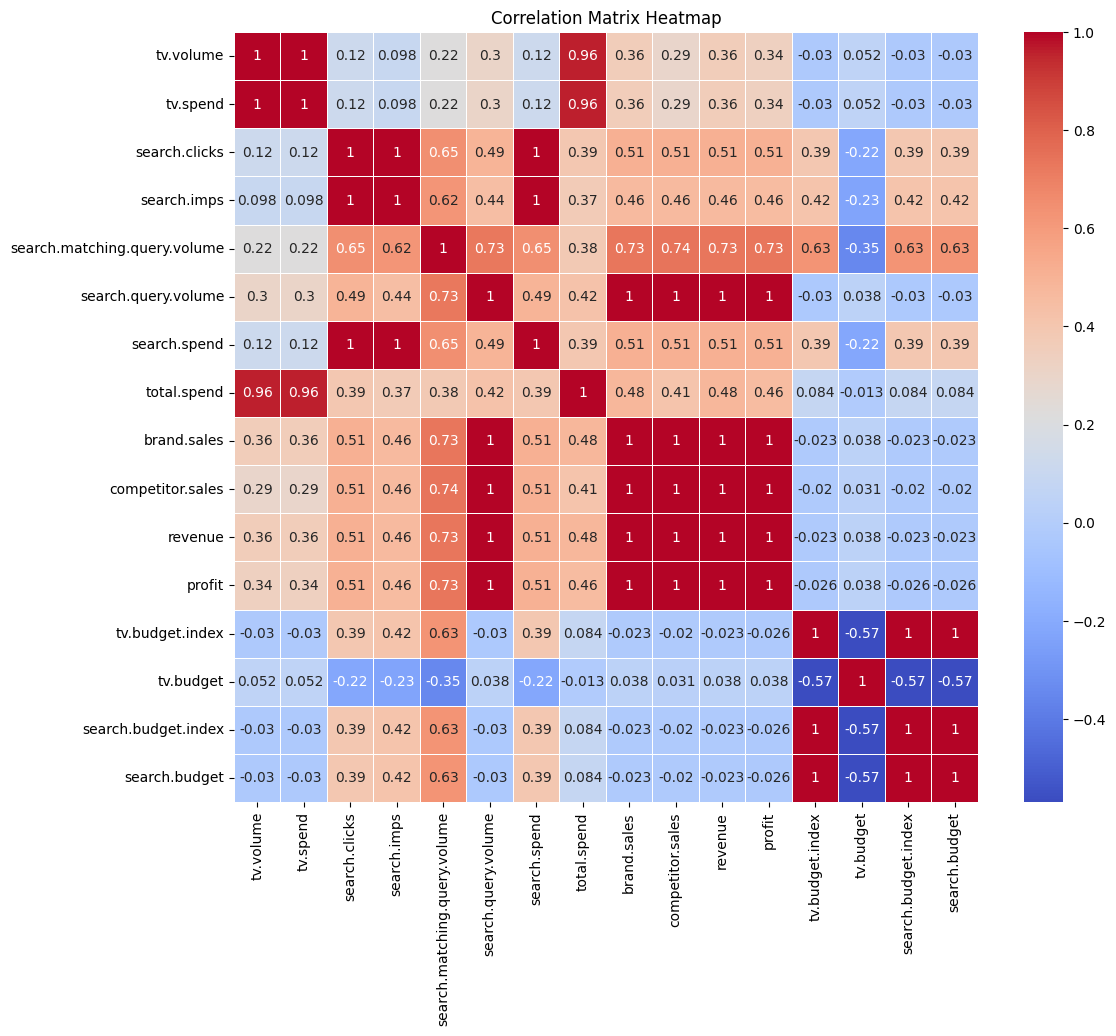

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<ipython-input-48-74acf9b5493b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['revenue'])


<Axes: xlabel='revenue', ylabel='Density'>

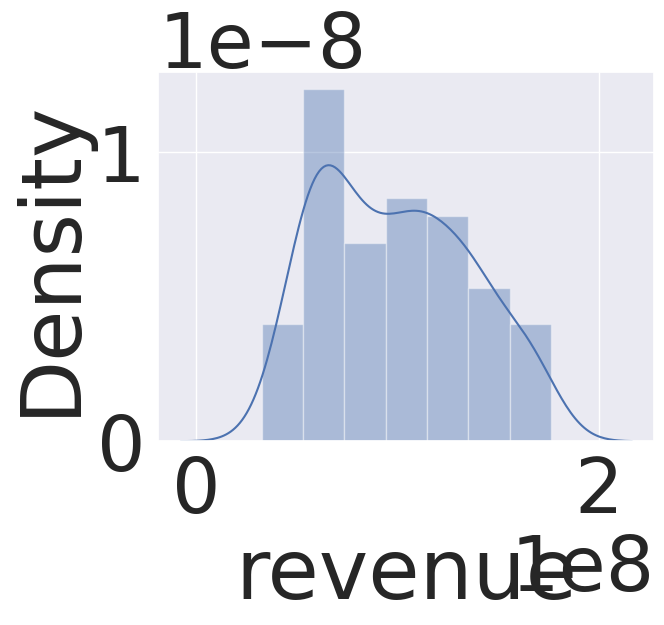

In [ ]:
# See distribution of target variable

sns.distplot(df['revenue'])

<ipython-input-16-07e6d36b2014>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['revenue'].apply(np.log), kde=True)


<Axes: xlabel='revenue', ylabel='Density'>

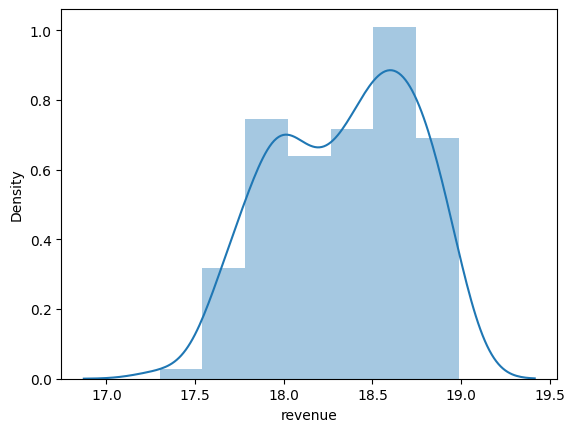

In [ ]:
# Log transform of target variable

sns.distplot(df['revenue'].apply(np.log), kde=True)

<ipython-input-17-fc8150c982b6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['revenue']**3)


<Axes: xlabel='revenue', ylabel='Density'>

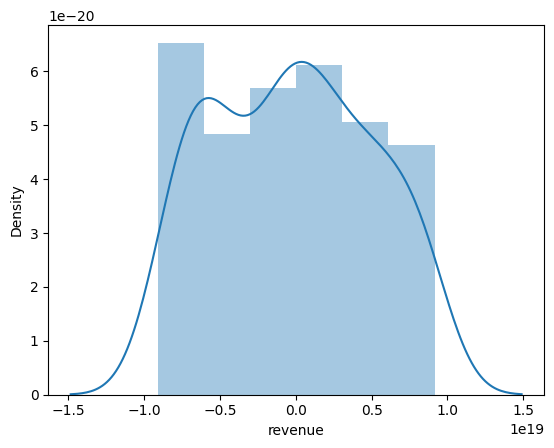

In [ ]:
# Third order polynomial
sns.distplot(df['revenue']**3)

The distribution of the target variable seems somewhat normal but right skewed. Using a log transform did not make the distribution more normal, but using a 3rd order polynomial transofrmation did. The [Pipeline section](#Pipeline) will apply data transformations.

In [ ]:
# Check correlation between variables
sales_corr = round(df.corr(),2)
sns.set(font_scale=5)
plt.subplots(figsize=(100,85))
sns.heatmap(sales_corr, cmap='YlGnBu', linewidth=.005, annot=True)

<Axes: >

# Select features and target variable for models

These models will attempt to predict revenue based on tv and search advertising spend. We will select only the marketing spend variables and revenue to use.

In [ ]:
# Create new data frame with variables intended to for use with models

sale_spend = df.loc[:, df.columns.intersection(['tv.spend', 'search.spend','revenue'])]

In [ ]:
# Check shape and top 5 rows

print(sale_spend.shape)
sale_spend.head()

(156, 3)


tv.spend  search.spend    revenue
time.index                                       
53          2.411204e+06           0.0  142329920
54          2.035003e+06      415753.2  106140160
55          9.502764e+05      537196.8  135150560
56          1.313284e+06      330709.2   83111360
57          0.000000e+00      685928.4  166430880

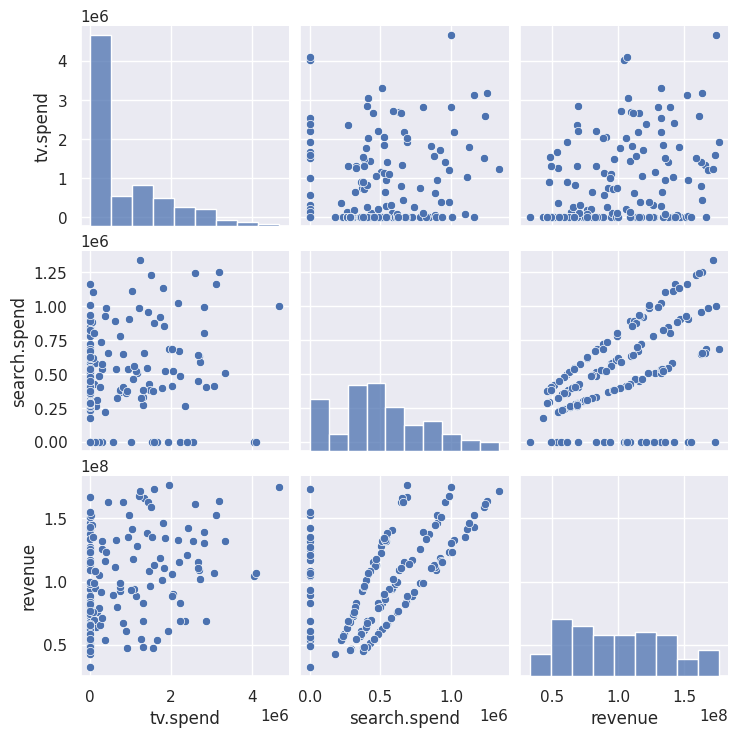

In [ ]:
# Check distribution of variables and relation to each other

sns.set(font_scale=1)

sns.pairplot(sale_spend)

# Feature Engineering

Some new features will be created to account for seasonality and other trends:
* tv.spend, search.spend, and revenue are shifted 52 weeks to create one year lag variables (_lag1y) for seasonality.
* Revenue will also be shifted one week (_lag1w) and three months (lag3m) to explore effects of delayed purchase after interacting with an advertisement.
* To explore advertising trends, rolling averages for both tv.spend and search.spend are calculated for one week (_p1w), three months (_p3m) , and one year (_p1y).

In [ ]:
# Create lag variables for 1y for revenue and channels to look for seasonality

sale_spend = pd.concat([sale_spend, sale_spend.shift(52).add_suffix('_lag1y')], axis=1)

sale_spend['revenue_lag1w'] = sale_spend['revenue'].shift()
sale_spend['revenue_lag3m'] = sale_spend['revenue'].shift(13)


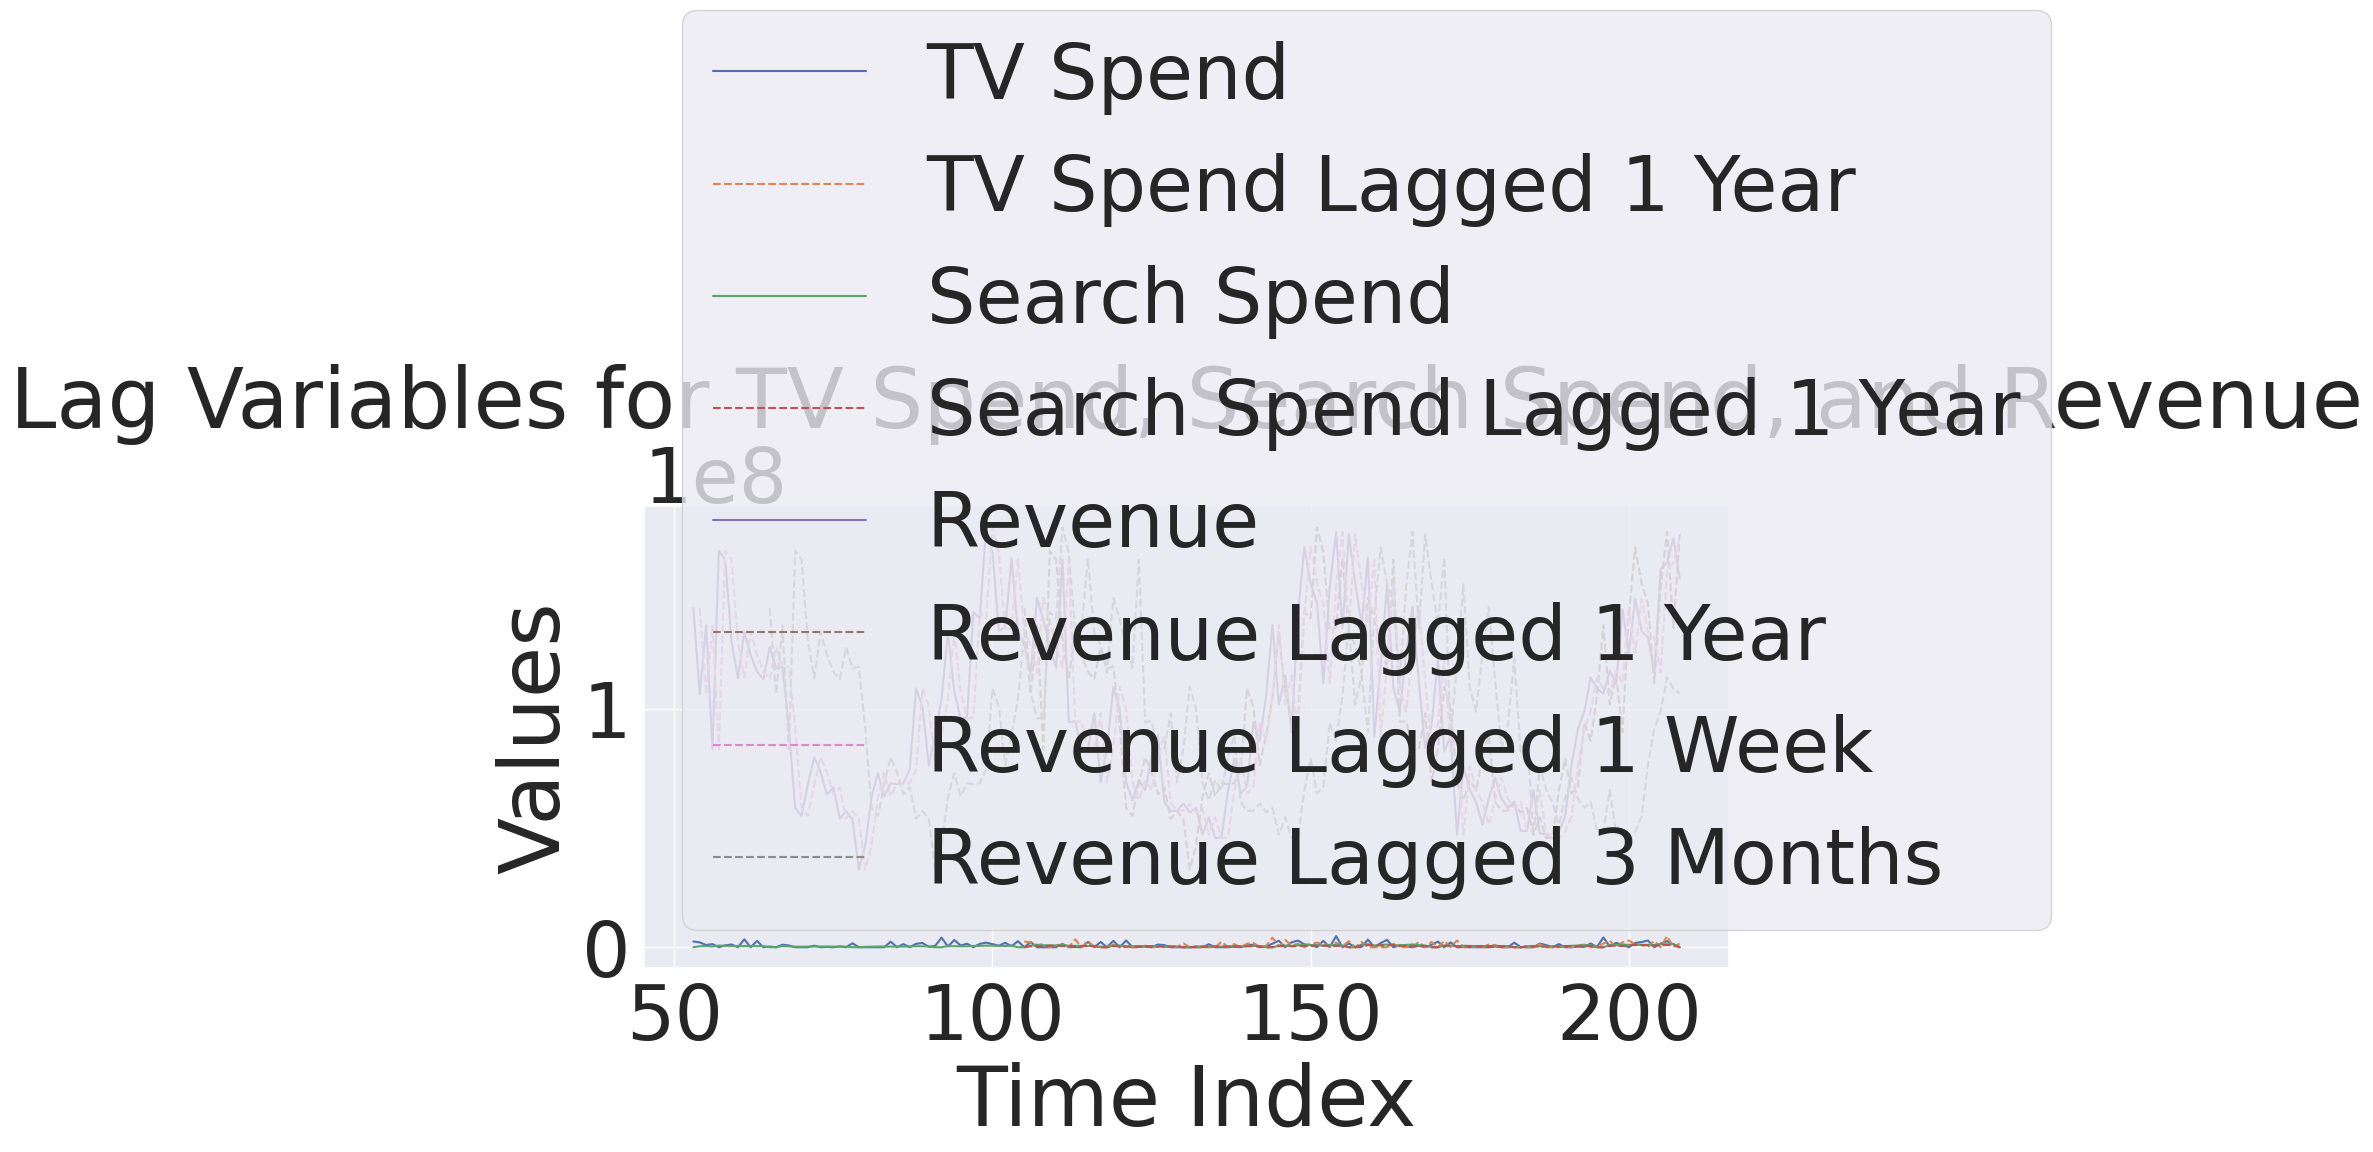

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataframe
# Read data and set existing index as dataframe index
df = pd.read_csv('OBSData2.csv', index_col=[0])

# Create lag variables
df['tv.spend_lag1y'] = df['tv.spend'].shift(52)
df['search.spend_lag1y'] = df['search.spend'].shift(52)
df['revenue_lag1y'] = df['revenue'].shift(52)
df['revenue_lag1w'] = df['revenue'].shift(1)
df['revenue_lag3m'] = df['revenue'].shift(12)

# Rolling averages
df['tv.spend_p1w'] = df['tv.spend'].rolling(window=1).mean()
df['tv.spend_p3m'] = df['tv.spend'].rolling(window=12).mean()
df['tv.spend_p1y'] = df['tv.spend'].rolling(window=52).mean()

df['search.spend_p1w'] = df['search.spend'].rolling(window=1).mean()
df['search.spend_p3m'] = df['search.spend'].rolling(window=12).mean()
df['search.spend_p1y'] = df['search.spend'].rolling(window=52).mean()

# Visualizing lag variables
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['tv.spend'], label='TV Spend')
plt.plot(df.index, df['tv.spend_lag1y'], label='TV Spend Lagged 1 Year', linestyle='--')
plt.plot(df.index, df['search.spend'], label='Search Spend')
plt.plot(df.index, df['search.spend_lag1y'], label='Search Spend Lagged 1 Year', linestyle='--')
plt.plot(df.index, df['revenue'], label='Revenue')
plt.plot(df.index, df['revenue_lag1y'], label='Revenue Lagged 1 Year', linestyle='--')
plt.plot(df.index, df['revenue_lag1w'], label='Revenue Lagged 1 Week', linestyle='--')
plt.plot(df.index, df['revenue_lag3m'], label='Revenue Lagged 3 Months', linestyle='--')
plt.title('Lag Variables for TV Spend, Search Spend, and Revenue')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.show()



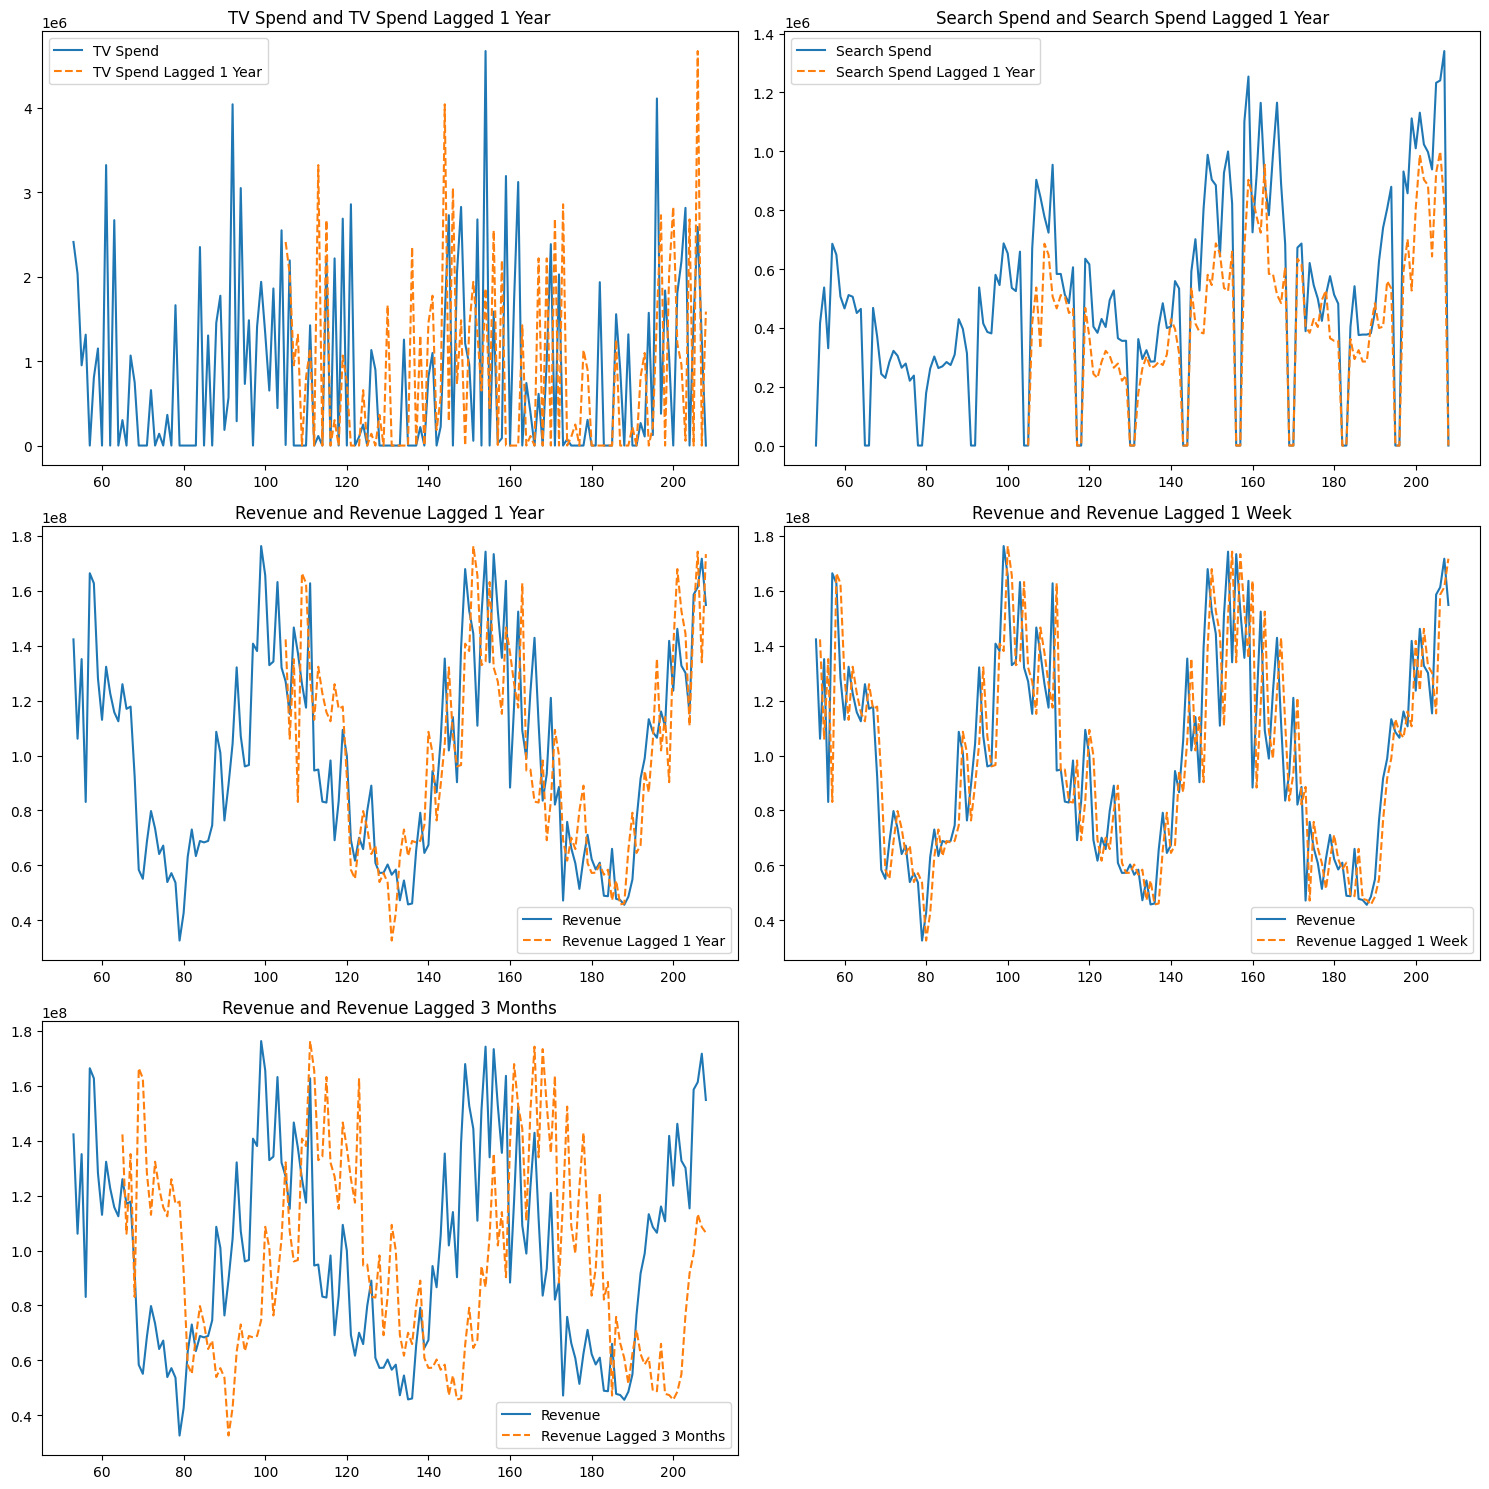

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataframe
# Read data and set existing index as dataframe index
df = pd.read_csv('OBSData2.csv', index_col=[0])

# Create lag variables
df['tv.spend_lag1y'] = df['tv.spend'].shift(52)
df['search.spend_lag1y'] = df['search.spend'].shift(52)
df['revenue_lag1y'] = df['revenue'].shift(52)
df['revenue_lag1w'] = df['revenue'].shift(1)
df['revenue_lag3m'] = df['revenue'].shift(12)

# Rolling averages
df['tv.spend_p1w'] = df['tv.spend'].rolling(window=1).mean()
df['tv.spend_p3m'] = df['tv.spend'].rolling(window=12).mean()
df['tv.spend_p1y'] = df['tv.spend'].rolling(window=52).mean()

df['search.spend_p1w'] = df['search.spend'].rolling(window=1).mean()
df['search.spend_p3m'] = df['search.spend'].rolling(window=12).mean()
df['search.spend_p1y'] = df['search.spend'].rolling(window=52).mean()

# Set up the subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot each lag variable
axs[0, 0].plot(df.index, df['tv.spend'], label='TV Spend')
axs[0, 0].plot(df.index, df['tv.spend_lag1y'], label='TV Spend Lagged 1 Year', linestyle='--')
axs[0, 0].set_title('TV Spend and TV Spend Lagged 1 Year')
axs[0, 0].legend()

axs[0, 1].plot(df.index, df['search.spend'], label='Search Spend')
axs[0, 1].plot(df.index, df['search.spend_lag1y'], label='Search Spend Lagged 1 Year', linestyle='--')
axs[0, 1].set_title('Search Spend and Search Spend Lagged 1 Year')
axs[0, 1].legend()

axs[1, 0].plot(df.index, df['revenue'], label='Revenue')
axs[1, 0].plot(df.index, df['revenue_lag1y'], label='Revenue Lagged 1 Year', linestyle='--')
axs[1, 0].set_title('Revenue and Revenue Lagged 1 Year')
axs[1, 0].legend()

axs[1, 1].plot(df.index, df['revenue'], label='Revenue')
axs[1, 1].plot(df.index, df['revenue_lag1w'], label='Revenue Lagged 1 Week', linestyle='--')
axs[1, 1].set_title('Revenue and Revenue Lagged 1 Week')
axs[1, 1].legend()

axs[2, 0].plot(df.index, df['revenue'], label='Revenue')
axs[2, 0].plot(df.index, df['revenue_lag3m'], label='Revenue Lagged 3 Months', linestyle='--')
axs[2, 0].set_title('Revenue and Revenue Lagged 3 Months')
axs[2, 0].legend()

# Hide the empty subplot
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


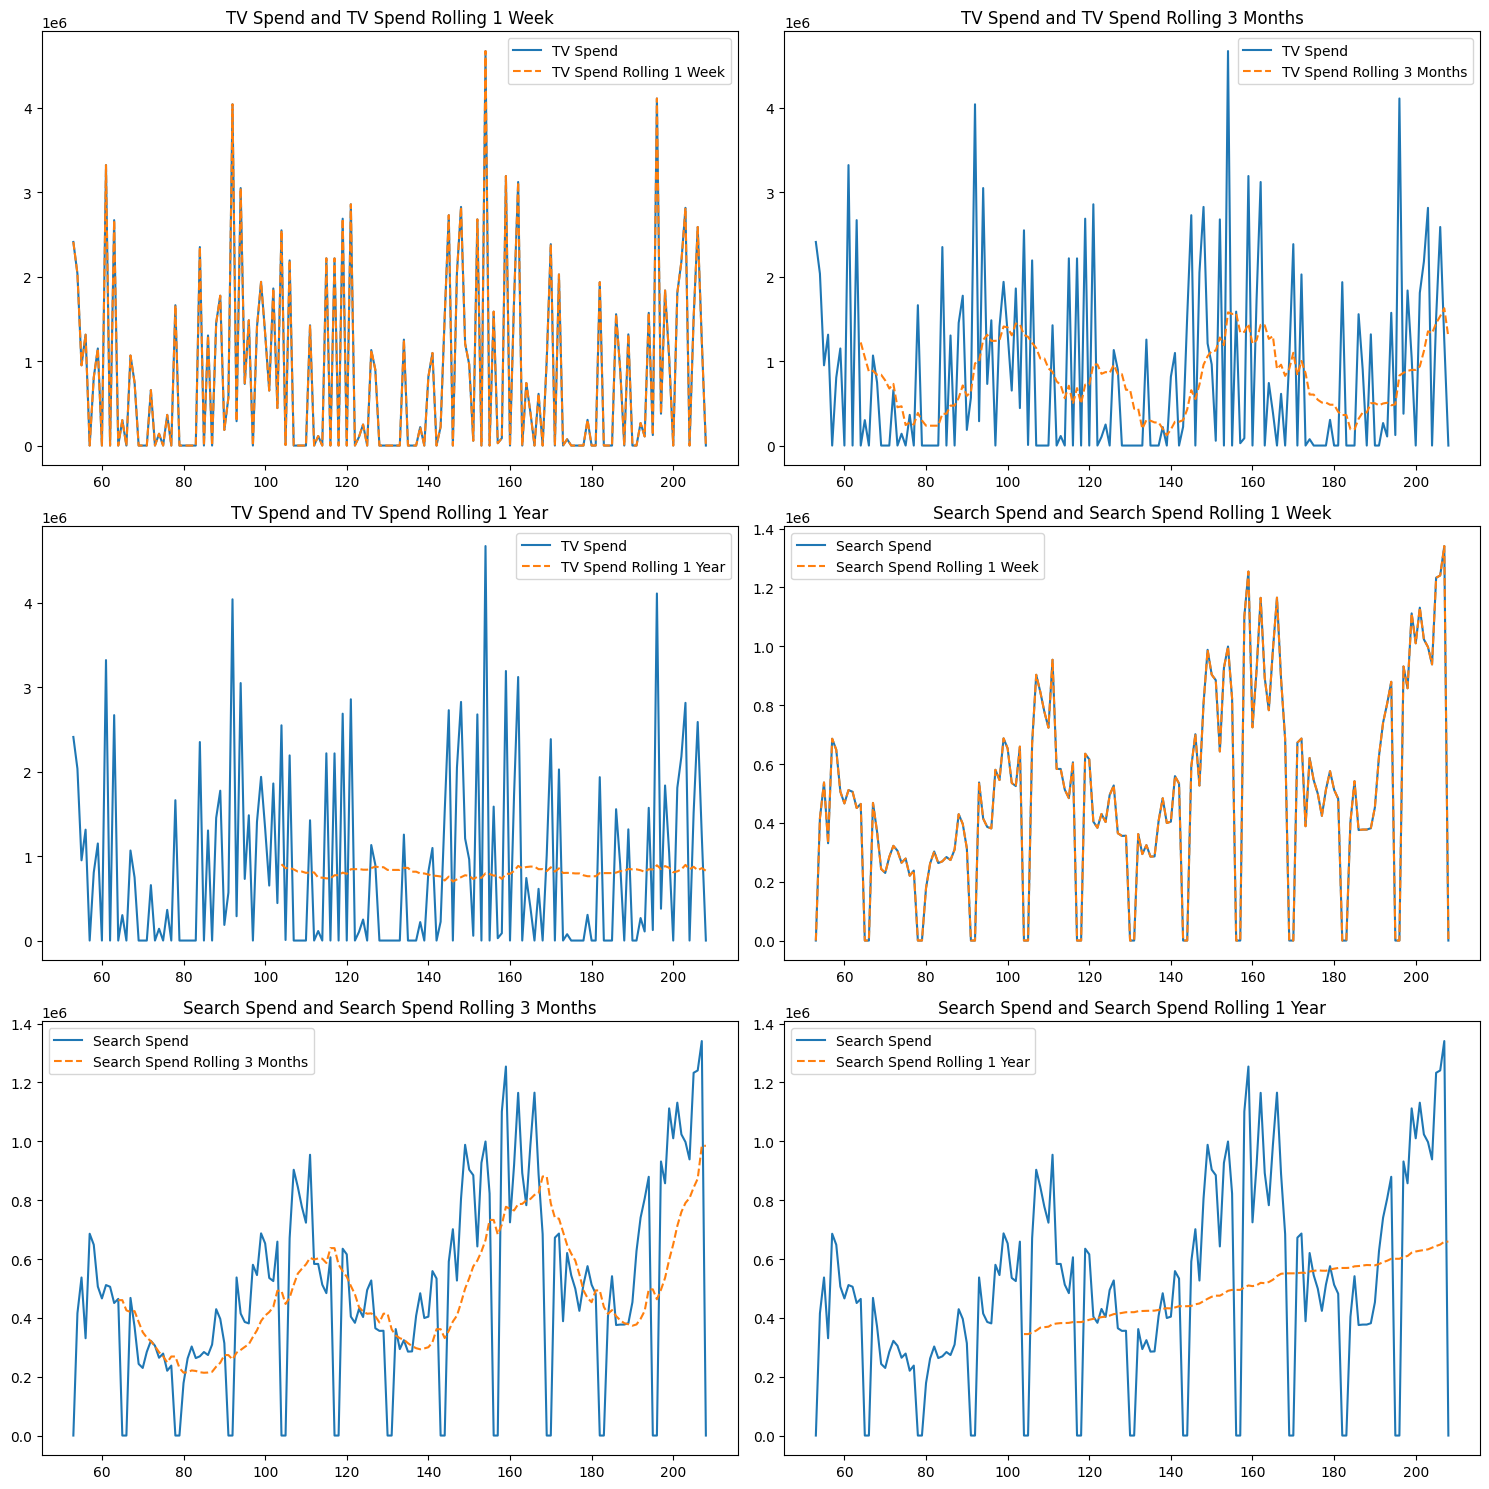

In [ ]:
# Set up the subplots for rolling averages
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot rolling averages for TV Spend
axs[0, 0].plot(df.index, df['tv.spend'], label='TV Spend')
axs[0, 0].plot(df.index, df['tv.spend_p1w'], label='TV Spend Rolling 1 Week', linestyle='--')
axs[0, 0].set_title('TV Spend and TV Spend Rolling 1 Week')
axs[0, 0].legend()

axs[0, 1].plot(df.index, df['tv.spend'], label='TV Spend')
axs[0, 1].plot(df.index, df['tv.spend_p3m'], label='TV Spend Rolling 3 Months', linestyle='--')
axs[0, 1].set_title('TV Spend and TV Spend Rolling 3 Months')
axs[0, 1].legend()

axs[1, 0].plot(df.index, df['tv.spend'], label='TV Spend')
axs[1, 0].plot(df.index, df['tv.spend_p1y'], label='TV Spend Rolling 1 Year', linestyle='--')
axs[1, 0].set_title('TV Spend and TV Spend Rolling 1 Year')
axs[1, 0].legend()

# Plot rolling averages for Search Spend
axs[1, 1].plot(df.index, df['search.spend'], label='Search Spend')
axs[1, 1].plot(df.index, df['search.spend_p1w'], label='Search Spend Rolling 1 Week', linestyle='--')
axs[1, 1].set_title('Search Spend and Search Spend Rolling 1 Week')
axs[1, 1].legend()

axs[2, 0].plot(df.index, df['search.spend'], label='Search Spend')
axs[2, 0].plot(df.index, df['search.spend_p3m'], label='Search Spend Rolling 3 Months', linestyle='--')
axs[2, 0].set_title('Search Spend and Search Spend Rolling 3 Months')
axs[2, 0].legend()

axs[2, 1].plot(df.index, df['search.spend'], label='Search Spend')
axs[2, 1].plot(df.index, df['search.spend_p1y'], label='Search Spend Rolling 1 Year', linestyle='--')
axs[2, 1].set_title('Search Spend and Search Spend Rolling 1 Year')
axs[2, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Create rolling average variable for 1y, 3m, and 1w for all channel spend

sale_spend = pd.concat([sale_spend, sale_spend.rolling(1).mean().add_suffix('_p1w'),
                        sale_spend.rolling(13).mean().add_suffix('_p3m'),
                        sale_spend.rolling(52).mean().add_suffix('_p1y')], axis=1)

In [ ]:
# Check shape and top 5 rows

print(sale_spend.shape)
sale_spend.head()

(156, 8)


tv.spend  search.spend    revenue  tv.spend_lag1y  \
time.index                                                          
53          2.411204e+06           0.0  142329920             NaN   
54          2.035003e+06      415753.2  106140160             NaN   
55          9.502764e+05      537196.8  135150560             NaN   
56          1.313284e+06      330709.2   83111360             NaN   
57          0.000000e+00      685928.4  166430880             NaN   

            search.spend_lag1y  revenue_lag1y  revenue_lag1w  revenue_lag3m  
time.index                                                                   
53                         NaN            NaN            NaN            NaN  
54                         NaN            NaN    142329920.0            NaN  
55                         NaN            NaN    106140160.0            NaN  
56                         NaN            NaN    135150560.0            NaN  
57                         NaN            NaN     83111360.0            NaN

In [ ]:
# View data types

sale_spend.dtypes

tv.spend              float64
search.spend          float64
revenue                 int64
tv.spend_lag1y        float64
search.spend_lag1y    float64
revenue_lag1y         float64
revenue_lag1w         float64
revenue_lag3m         float64
dtype: object

In [ ]:
# Drop extra columns generated from column shift and concatenation
sale_spend = sale_spend.loc[:, ~sale_spend.columns.duplicated()]
#sale_spend.drop(['revenue_p1w', 'revenue_p3m', 'revenue_p1y'], axis=1, inplace=True)
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1y_p1w')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1y_p3m')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1y_p1y')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1w_p1w')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag3m_p1w')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1w_p3m')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag3m_p3m')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag1w_p1y')]
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_lag3m_p1y')]

In [ ]:
# Check shape and top 5 rows

print(sale_spend.shape)
sale_spend.head()

(156, 8)


tv.spend  search.spend    revenue  tv.spend_lag1y  \
time.index                                                          
53          2.411204e+06           0.0  142329920             NaN   
54          2.035003e+06      415753.2  106140160             NaN   
55          9.502764e+05      537196.8  135150560             NaN   
56          1.313284e+06      330709.2   83111360             NaN   
57          0.000000e+00      685928.4  166430880             NaN   

            search.spend_lag1y  revenue_lag1y  revenue_lag1w  revenue_lag3m  
time.index                                                                   
53                         NaN            NaN            NaN            NaN  
54                         NaN            NaN    142329920.0            NaN  
55                         NaN            NaN    106140160.0            NaN  
56                         NaN            NaN    135150560.0            NaN  
57                         NaN            NaN     83111360.0            NaN

In [ ]:
#Check for nulls
missing_data = sale_spend.isnull().sum()
missing_data

tv.spend               0
search.spend           0
revenue                0
tv.spend_lag1y        52
search.spend_lag1y    52
revenue_lag1y         52
revenue_lag1w          1
revenue_lag3m         13
dtype: int64

In [ ]:
# Drop nulls
sale_spend = sale_spend.dropna()
sale_spend.shape

(104, 8)

<Axes: >

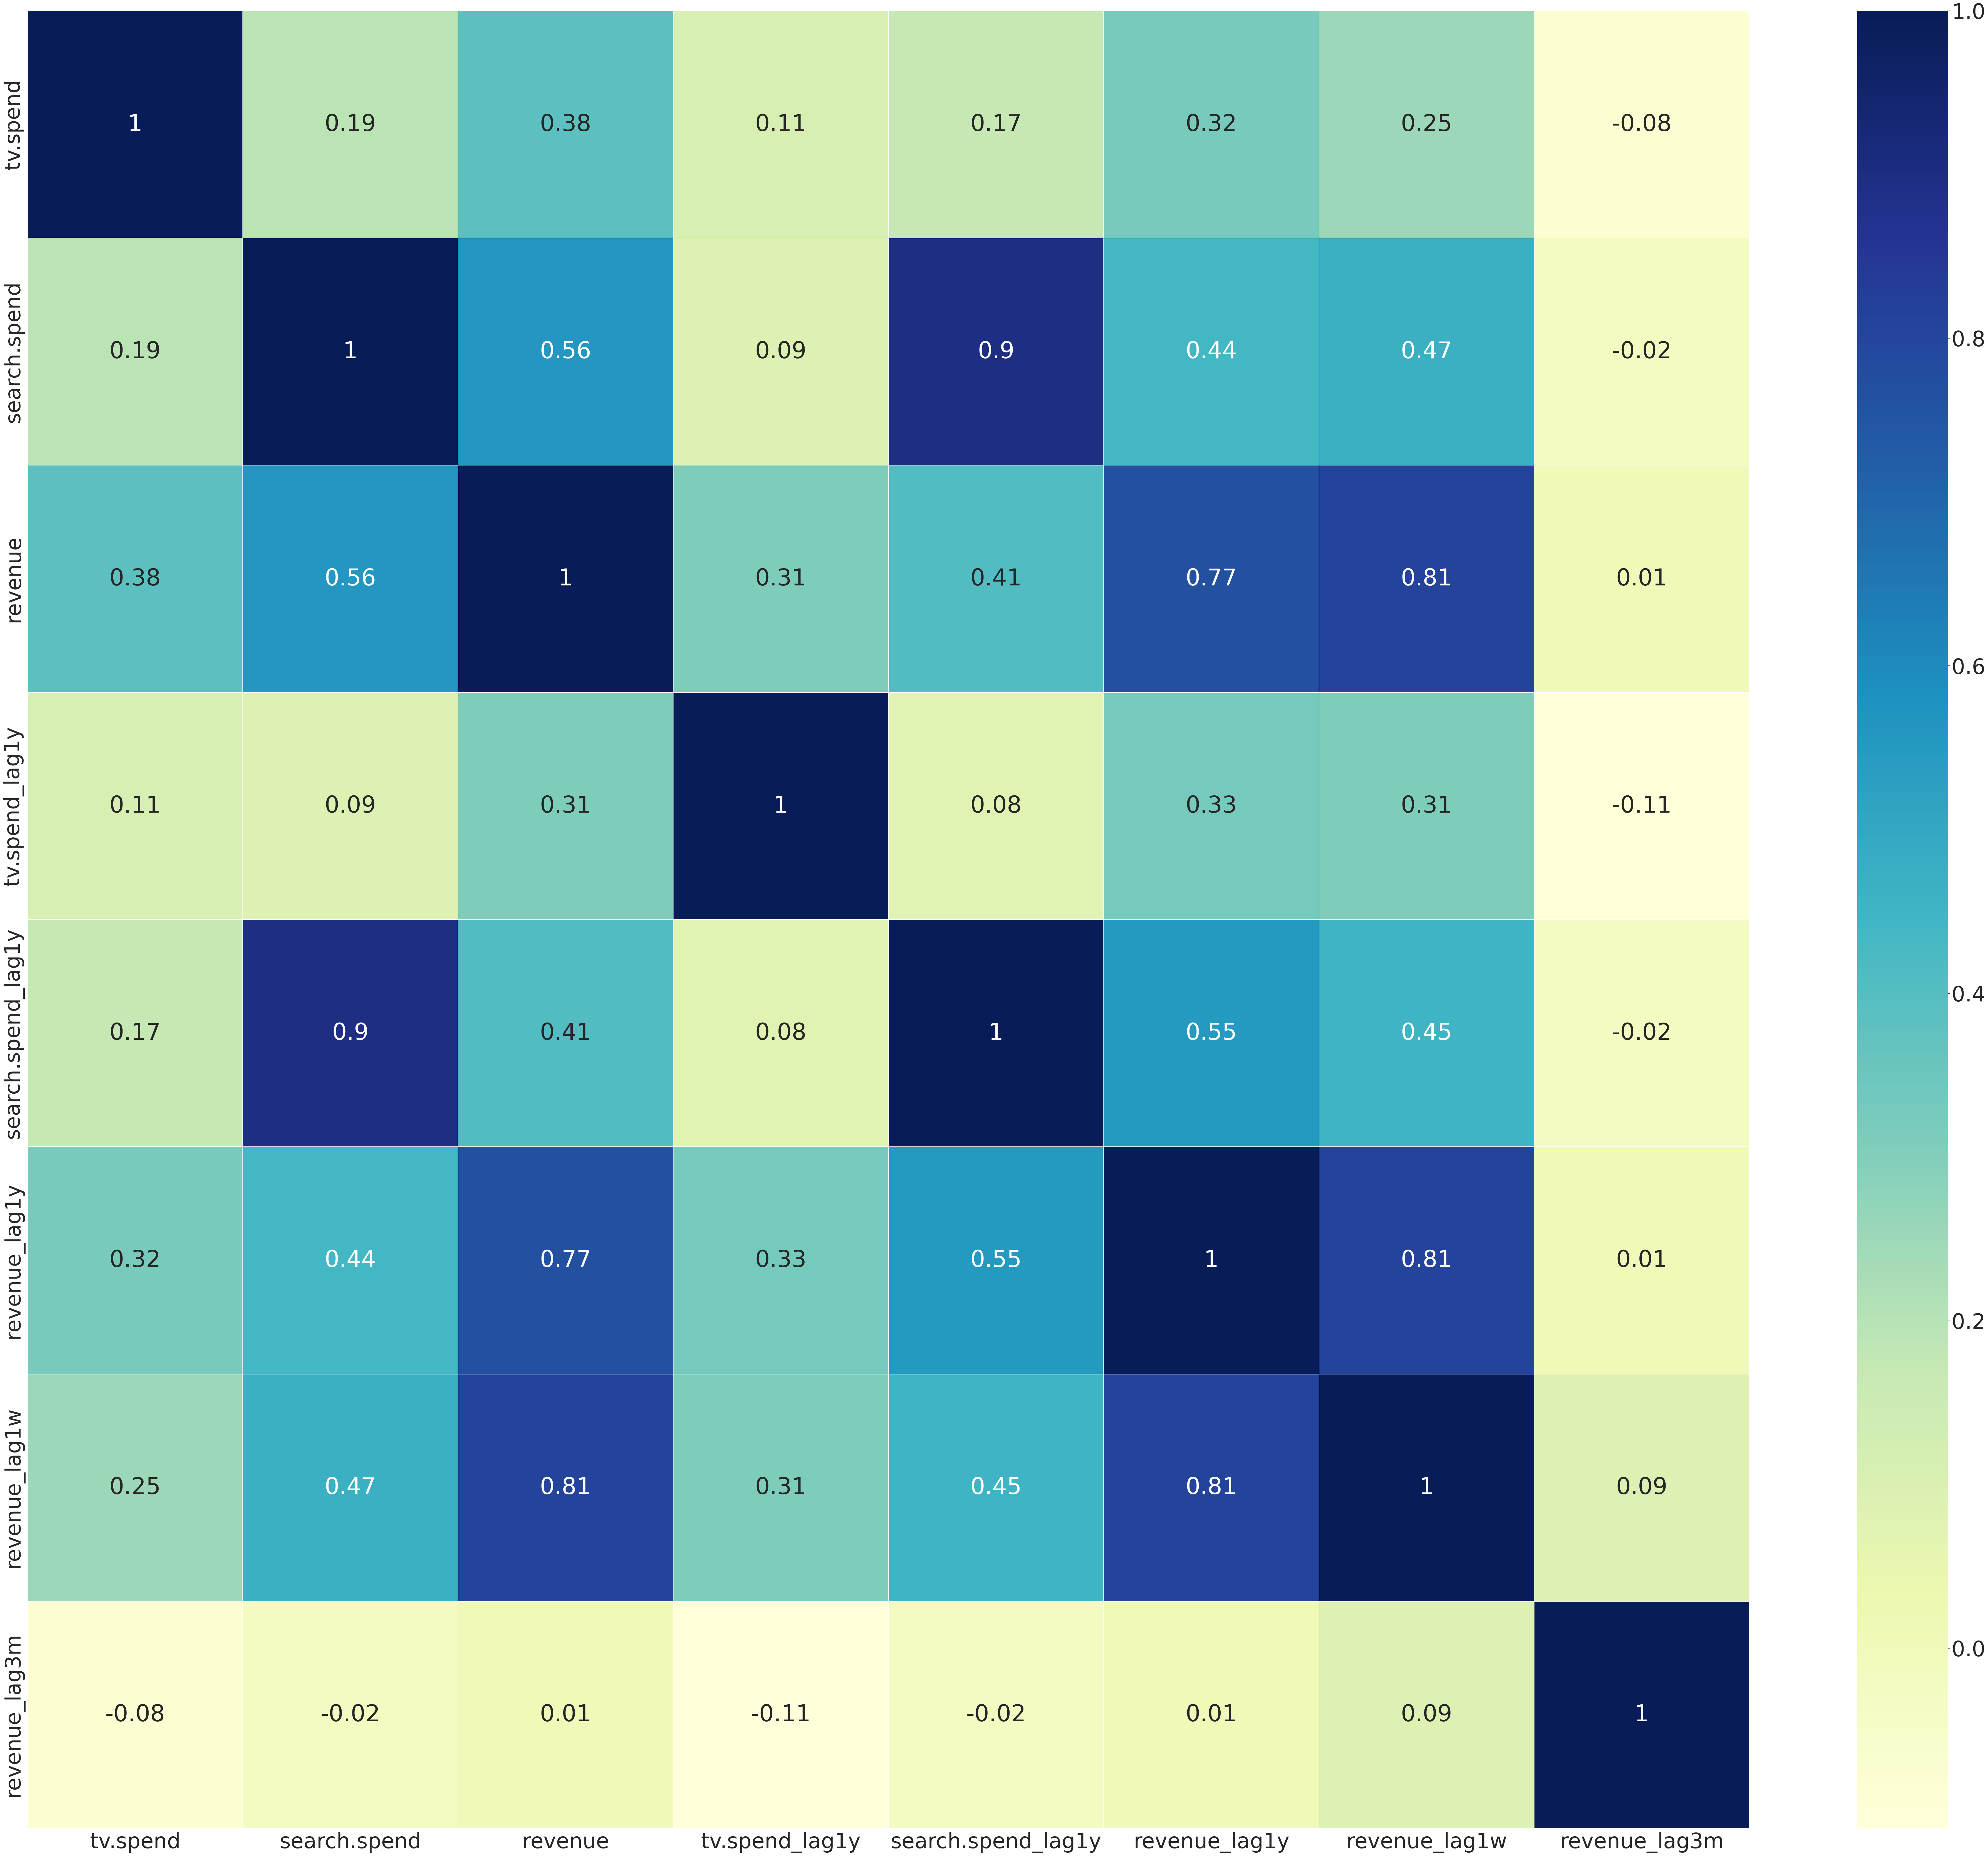

In [ ]:
# Check correlation of new variables

sales_corr = round(sale_spend.corr(),2)
sns.set(font_scale=5)
plt.subplots(figsize=(100,85))

sns.heatmap(sales_corr, cmap='YlGnBu', linewidth=.005, annot=True)

tv.spend_p1w and search.spend_p1w are removed due to extremely high correlation. Other variable with correlation greater than 0.8 will remain as they could contribute information about seasonality, delayed purchase after an advertisement, or decaying interest after an advertisement.

In [ ]:
# Remove '_p1w' variables due to high correlation (corr = 1).
sale_spend = sale_spend.loc[:, ~sale_spend.columns.str.endswith('_p1w')]

In [ ]:
# Check shape and top 5 rows
print(sale_spend.shape)
sale_spend.head()

(104, 8)


tv.spend  search.spend    revenue  tv.spend_lag1y  \
time.index                                                          
105         6.807816e+03           0.0  127001520    2.411204e+06   
106         2.192875e+06      670747.2  115202800    2.035003e+06   
107         0.000000e+00      903260.4  146658960    9.502764e+05   
108         0.000000e+00      845278.8  137441600    1.313284e+06   
109         0.000000e+00      777514.8  126147120    0.000000e+00   

            search.spend_lag1y  revenue_lag1y  revenue_lag1w  revenue_lag3m  
time.index                                                                   
105                        0.0    142329920.0    132040720.0    104321680.0  
106                   415753.2    106140160.0    127001520.0    132141760.0  
107                   537196.8    135150560.0    115202800.0    107124880.0  
108                   330709.2     83111360.0    146658960.0     96055760.0  
109                   685928.4    166430880.0    137441600.0     96551040.0

# Prepare data for pipeline

In [ ]:
# Separate target and independant variables
y = sale_spend['revenue']
X = sale_spend.loc[:, sale_spend.columns != 'revenue']

In [ ]:
# For each X, calculate VIF and save in dataframe

vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
# View VIF dataframe

vif.round(1)

Features  VIF Factor
0            tv.spend         1.8
1        search.spend        25.2
2      tv.spend_lag1y         1.9
3  search.spend_lag1y        27.6
4       revenue_lag1y        33.5
5       revenue_lag1w        29.2
6       revenue_lag3m         5.0

Most variables show very high VIF values, indicating a high degree of multicolinearity. This is expected given the interrelation of variables as well as new features.

In [ ]:
# Create decision tree to help determine feature importance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

<Axes: >

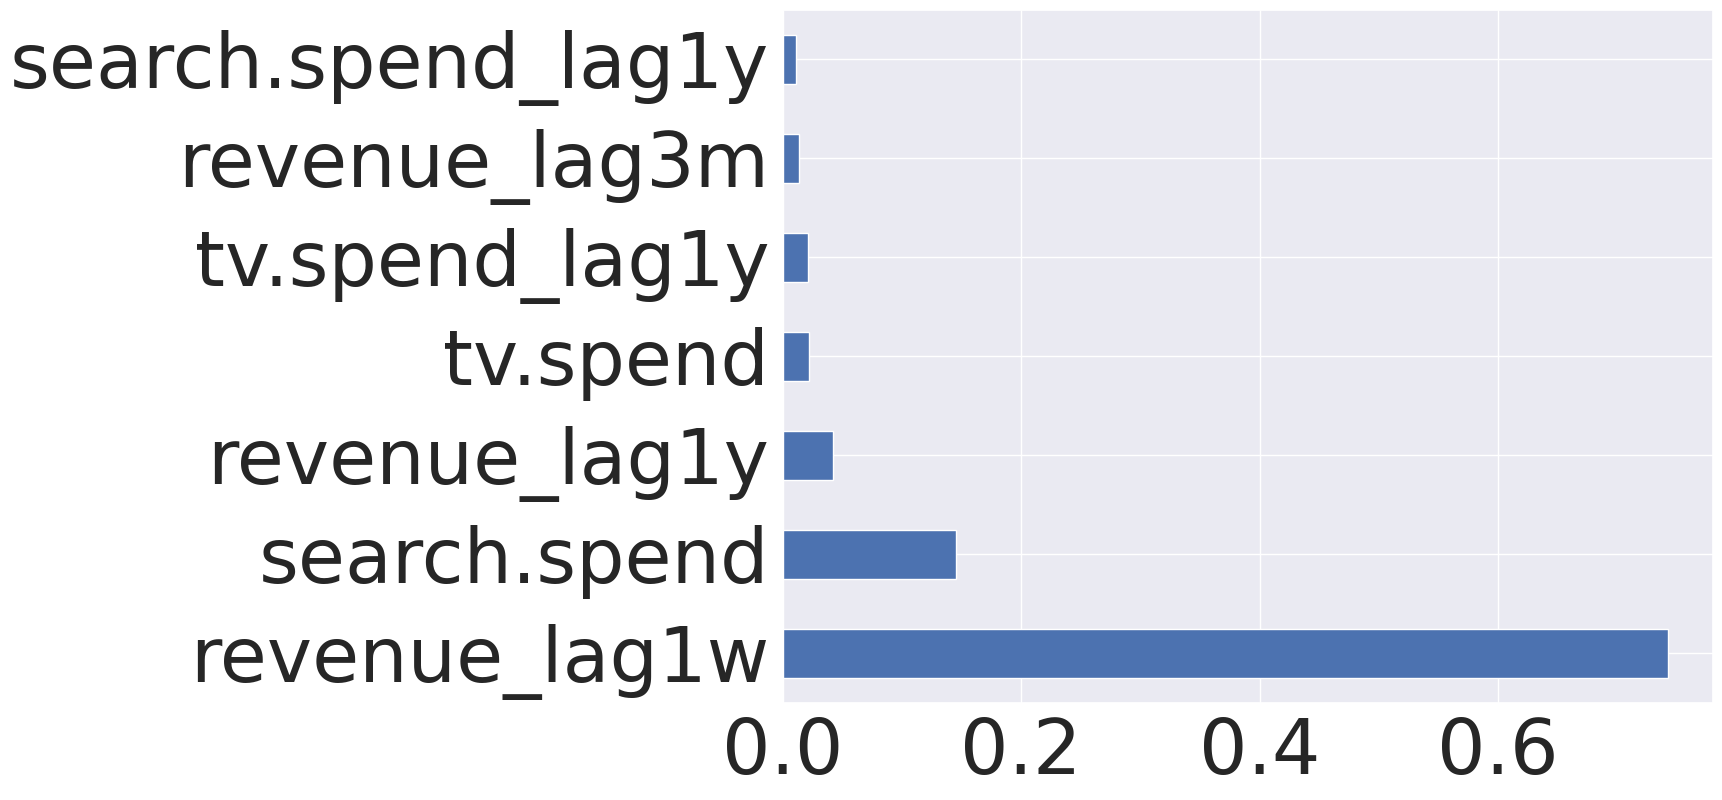

In [ ]:
# Visualize feature importance based on decision tree

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(12,9))

revenue_lag1y seems to be the most important feature based on this decision tree, indicating seasonality could be a factor in weekly revenue. tv.spend may also be on a seasonal schedule.

# Pipeline


In [ ]:
# Make sure dataframes are compatible shapes

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(72, 7) (32, 7)
(72,) (32,)


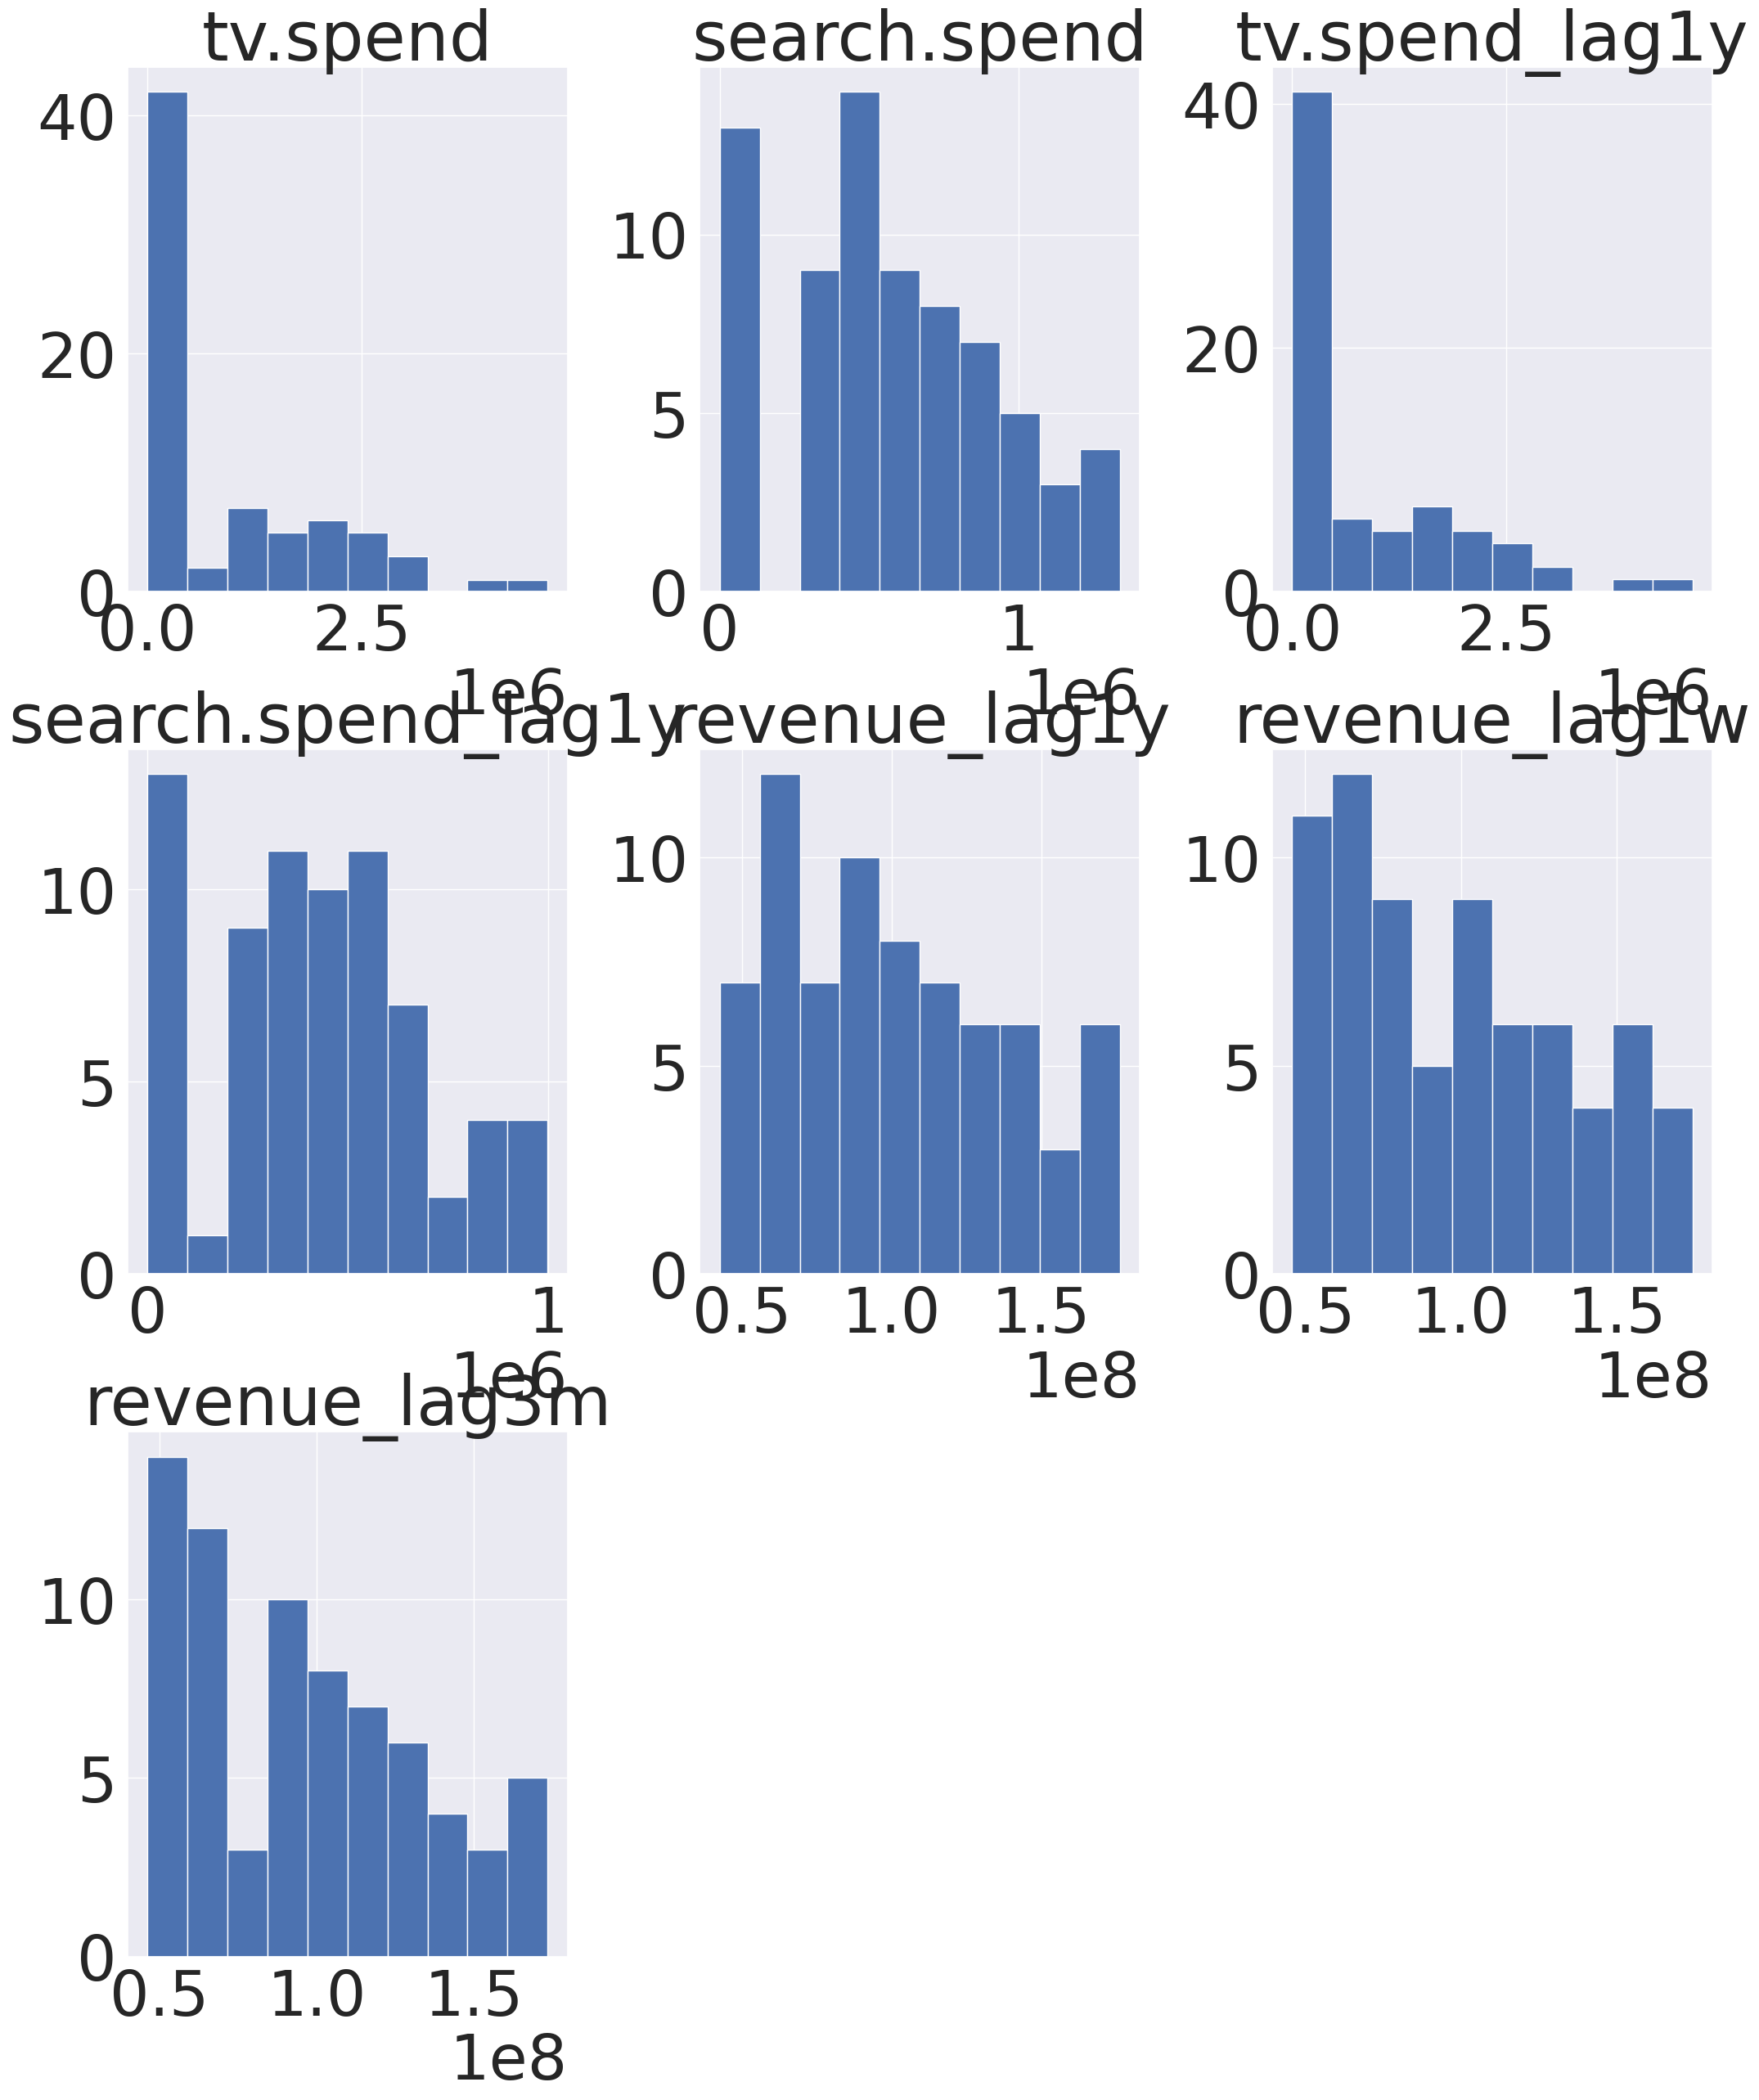

In [ ]:
# View training feature distribution before transform

X_train.hist(figsize=(25, 30))
plt.show()

# Baseline

A baseline error is measured  by forecasting the mean weekly revenue for all predictions.

In [ ]:
# Calculate mean revenue

mean_value = np.mean(y_train)

mean_value

99117867.77777778

In [ ]:
# Predict all values as the mean

base_pred = np.repeat(mean_value, len(y_test))

base_pred

array([99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778, 99117867.77777778,
       99117867.77777778, 99117867.77777778])

In [ ]:
# Calculate error to establish baseline measurements

base_mse = mean_squared_error(y_test, base_pred)

base_rmse = np.sqrt(base_mse)
base_mape = mean_absolute_percentage_error(y_test, base_pred)
base_r_sq = r2_score(y_test, base_pred)

print('Baseline RMSE: {}' .format(base_rmse))
print('Baseline MAPE: {}' .format(base_mape))
print('Baseline R2: {}' .format(base_r_sq))

Baseline RMSE: 40148073.114140846
Baseline MAPE: 0.4588038735556378
Baseline R2: -0.003560832372672351


# Linear Regression

The first model is an ordinary least squares (OLS) regression with all original variables.

In [ ]:
# Split original dataframe to train/test

y_all = df['revenue']
x_all = df.loc[:, df.columns != 'revenue']


x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(x_all, y_all, test_size=.3, random_state=0)

In [ ]:
# Kitchen sink linear regression model from original dataframe

lr_model = LinearRegression()

lr_model.fit(x_train_all, y_train_all)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#Train RMSE

reg_train_pred = lr_model.predict(x_train_all)

lr_train_mse = mean_squared_error(y_train_all, reg_train_pred)
lr_train_rmse = np.sqrt(mean_squared_error (y_train_all, reg_train_pred))

lr_train_mape = mean_absolute_percentage_error(y_train_all, reg_train_pred)
lr_train_r_sq = r2_score(y_train_all, reg_train_pred)

print('Train RMSE: {}' .format(lr_train_rmse))
print('Train MAPE: {}' .format(lr_train_mape))
print('Train R2: {}' .format(lr_train_r_sq))

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#Test RMSE

reg_test_pred = lr_model.predict(x_test_all)

lr_test_mse = mean_squared_error (y_test_all, reg_test_pred)

lr_test_rmse = np.sqrt(mean_squared_error (y_test_all, reg_test_pred))
lr_test_mape = mean_absolute_percentage_error(y_test_all, reg_test_pred)
lr_test_r_sq = r2_score(y_test_all, reg_test_pred)


print('Test RMSE: {}' .format(lr_test_rmse))
print('Test MAPE: {}' .format(lr_test_mape))
print('Test R2: {}' .format(lr_test_r_sq))

Test RMSE: 1.7509960538080992e-07
Test MAPE: 1.3370719658870523e-15
Test R2: 1.0


<b>Impression: </b>R2 is incredibly high while RMSE and MAPE are incredibly low. The "kitchen sink" model is most likely overfit and not a good choice.

# Linear Regression Simplified

A simplified OLS regression will also be done to guage how well using only tv.spend and search.spend can predict revenue.

In [ ]:
# Create train/ test variables using only two features: tv.spend and search.spend

y_simple = df['revenue']
x_simple = df[['tv.spend','search.spend']]


x_train_simple, x_test_simple, y_train_simple, y_test_simple = train_test_split(x_simple, y_simple, test_size=.3, random_state=0)

In [ ]:
# Fit previously instantiated LR model on simplified data

lr_model.fit(x_train_simple, y_train_simple)

LinearRegression()

In [ ]:
#Train RMSE

reg_train_pred = lr_model.predict(x_train_simple)

lrsimp_train_mse = mean_squared_error(y_train_simple, reg_train_pred)
lrsimp_train_rmse = np.sqrt(mean_squared_error (y_train_simple, reg_train_pred))
lrsimp_train_mape = mean_absolute_percentage_error(y_train_simple, reg_train_pred)
lrsimp_train_r_sq = r2_score(y_train_simple, reg_train_pred)

print('Train RMSE: {}' .format(lrsimp_train_rmse))
print('Train MAPE: {}' .format(lrsimp_train_mape))
print('Train R2: {}' .format(lrsimp_train_r_sq))

Train RMSE: 31301500.381631754
Train MAPE: 0.2914964283155746
Train R2: 0.27718402338577064


In [ ]:
#Test RMSE

reg_test_pred = lr_model.predict(x_test_simple)

lrsimp_test_mse = mean_squared_error(y_test_simple, reg_test_pred)
lrsimp_test_rmse = np.sqrt(mean_squared_error (y_test_simple, reg_test_pred))
lrsimp_test_mape = mean_absolute_percentage_error(y_test_simple, reg_test_pred)
lrsimp_test_r_sq = r2_score(y_test_simple, reg_test_pred)

print('test RMSE: {}' .format(lrsimp_test_rmse))
print('test MAPE: {}' .format(lrsimp_test_mape))
print('test R2: {}' .format(lrsimp_test_r_sq))

test RMSE: 25002339.098568905
test MAPE: 0.28485559626338164
test R2: 0.5235717240078526


<b>Impression: </b>R2 is very low while RMSE and MAPE are not greatly improved over the baseline. The simplified model with only two predictor variables is insufficient as it shows signs of underfitting.

# Linear Regression with lag variables

Next, another OLS regression is done this time only using tv.spend, search.spend, and the engineered features (lag and rolling average variables).

In [ ]:
# Linear model - spend and lag/rolling avg variables

lr_lagmodel = LinearRegression()

lr_lagmodel.fit(X_train, y_train)

LinearRegression()

In [ ]:
#Train RMSE

reg_train_pred = lr_lagmodel.predict(X_train)

lrlag_train_mse = mean_squared_error(y_train, reg_train_pred)
lrlag_train_rmse = np.sqrt(mean_squared_error (y_train, reg_train_pred))
lrlag_train_mape = mean_absolute_percentage_error(y_train, reg_train_pred)
lrlag_train_r_sq = r2_score(y_train, reg_train_pred)

print('Train RMSE: {}' .format(lrlag_train_rmse))
print('Train MAPE: {}' .format(lrlag_train_mape))
print('Train R2: {}' .format(lrlag_train_r_sq))

Train RMSE: 11318698.810821682
Train MAPE: 0.0839791973343112
Train R2: 0.8978978828723705


In [ ]:
#Test RMSE

reg_test_pred = lr_lagmodel.predict(X_test)

lrlag_test_mse = mean_squared_error (y_test, reg_test_pred)
lrlag_test_rmse = np.sqrt(mean_squared_error (y_test, reg_test_pred))
lrlag_test_mape = mean_absolute_percentage_error(y_test, reg_test_pred)
lrlag_test_r_sq = r2_score(y_test, reg_test_pred)


print('Test RMSE: {}' .format(lrlag_test_rmse))
print('Test MAPE: {}' .format(lrlag_test_mape))
print('Test R2: {}' .format(lrlag_test_r_sq))

Test RMSE: 14709967.90778366
Test MAPE: 0.1237245516248992
Test R2: 0.8652782421783174


In [ ]:
y_pred_train = lr_lagmodel.predict(X_train)
y_pred_test = lr_lagmodel.predict(X_test)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train))
train_r2 = r2_score(y_train, y_pred_train)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test))
test_r2 = r2_score(y_test, y_pred_test)
print(f'Train RMSE: {train_rmse}')
print(f'Train MAPE: {train_mape}')
print(f'Train R2: {train_r2}')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAPE: {test_mape}')
print(f'Test R2: {test_r2}')

Train RMSE: 11318698.810821682
Train MAPE: 0.0839791973343112
Train R2: 0.8978978828723705
Test RMSE: 14709967.90778366
Test MAPE: 0.1237245516248992
Test R2: 0.8652782421783174


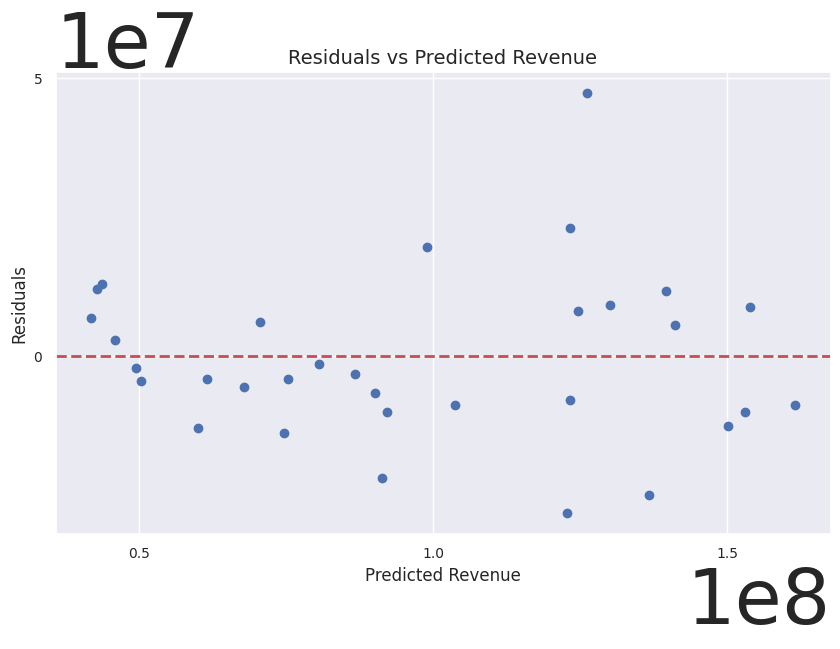

In [ ]:
# Residual plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, linestyle='--', color='r', linewidth=2)
plt.xlabel('Predicted Revenue',  fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residuals vs Predicted Revenue',  fontsize=14)
plt.xticks( fontsize=10)
plt.yticks( fontsize=10)
plt.show()

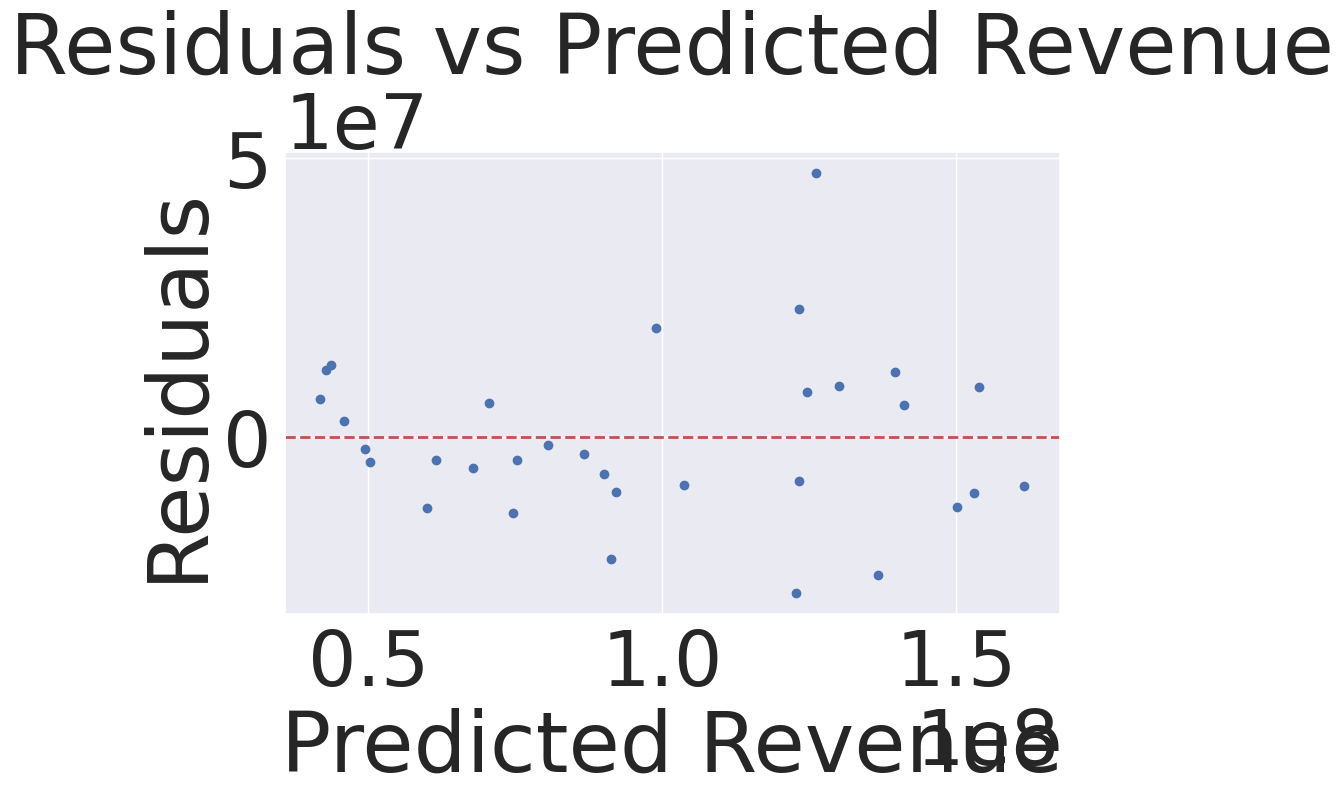

In [ ]:
# Residual plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, linestyle='--', color='r', linewidth=2)
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Revenue')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('OBSData2.csv', index_col=[0])

# Feature engineering (assuming previous steps have been done)
df['tv.spend_lag1y'] = df['tv.spend'].shift(52)
df['search.spend_lag1y'] = df['search.spend'].shift(52)
df['revenue_lag1y'] = df['revenue'].shift(52)
df['revenue_lag1w'] = df['revenue'].shift(1)
df['revenue_lag3m'] = df['revenue'].shift(12)
df['tv.spend_p1w'] = df['tv.spend'].rolling(window=1).mean()
df['tv.spend_p3m'] = df['tv.spend'].rolling(window=12).mean()
df['tv.spend_p1y'] = df['tv.spend'].rolling(window=52).mean()
df['search.spend_p1w'] = df['search.spend'].rolling(window=1).mean()
df['search.spend_p3m'] = df['search.spend'].rolling(window=12).mean()
df['search.spend_p1y'] = df['search.spend'].rolling(window=52).mean()

# Define features and target variable
features = ['tv.spend', 'search.spend', 'tv.spend_lag1y', 'search.spend_lag1y',
            'revenue_lag1w', 'revenue_lag3m', 'tv.spend_p1w', 'tv.spend_p3m',
            'tv.spend_p1y', 'search.spend_p1w', 'search.spend_p3m', 'search.spend_p1y']
target = 'revenue'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection and training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Model validation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train))
train_r2 = r2_score(y_train, y_pred_train)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test))
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train RMSE: {train_rmse}')
print(f'Train MAPE: {train_mape}')
print(f'Train R2: {train_r2}')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAPE: {test_mape}')
print(f'Test R2: {test_r2}')

# Visualization: Predicted vs. Actual Revenue Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

# Residual plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, linestyle='--', color='r', linewidth=2)
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Revenue')
plt.show()


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<b>Impression:</b> RMSE and MAPE are greatly improved over baseline using selected features. The model does not show signs of overfitting.

# Model Comparison

To select the best model, root mean squared error (RMSE) and Mean absolute percentage error (MAPE) will be compared. The kitchen sink OLS, simplified OLS, and polynomial regression models have been removed due to overfitting and underfitting.

For the remaining models, RMSE will be used to compare overall error of the models. MAPE and r-squared (R2) will be compared to guage overall model quality and fit. Higher R2 indicates better fit while lower RMSE and MAPE indicate better models. Additionally, the train MAPE and test MAPE should not differ by more than twp percent-points, but a zero percent-point difference could indicate overfitting.

In [ ]:
# Add metrics to model_eval dictionary.

model_eval = {
    'lin_reg_lag': [{'RMSE': lrlag_test_rmse},{'Train MAPE': lrlag_train_mape}, {'Test MAPE': lrlag_test_mape}, {'R2': lrlag_test_r_sq }]
}

# Create data frame from dictionary
model_evaldf = pd.DataFrame.from_dict(model_eval)

model_evaldf

lin_reg_lag
0          {'RMSE': 7249842.320900645}
1  {'Train MAPE': 0.05610385787014813}
2   {'Test MAPE': 0.05453639749163891}
3           {'R2': 0.9495154659048988}

Lowest RMSE: lasso (7,071,077.81)<br>
Lowest MAPE: elastic-net (0.0541)<br>
Highest R^2: lasso (0.95197444)

# Best Model

Of the models explored, four were very similar in terms of lowest error. The ordinary linear regression with lag variables (lin_reg_lag), elastic net (elastic_net), stochastic gradient descent (SGD), lasso regression (lasso), and ridge regression (ridge) models all had RMSE of approximately 7.1 million and  MAPE around 5%.

The "best" of those models is lasso as it has the lowest RMSE in addition to having a low test MAPE and low variation between test and train MAPE.

# Interpretation

In [ ]:
slope = lr_lagmodel.coef_
intercept = lr_lagmodel.intercept_

In [ ]:
slope, intercept

(array([ 3.80180302e+00,  1.51307815e+02, -2.78419125e+00, -1.94725327e+02,
         7.35565643e-01,  1.34048124e-01, -2.90286191e-02, -8.83394834e+00,
         1.37869927e+01,  5.22856446e+01,  2.13247364e+01]),
 -37100746.75897488)

In [ ]:
lr_lagmodel.feature_names_in_

array(['tv.spend', 'search.spend', 'tv.spend_lag1y', 'search.spend_lag1y',
       'revenue_lag1y', 'revenue_lag1w', 'revenue_lag3m', 'tv.spend_p3m',
       'search.spend_p3m', 'tv.spend_p1y', 'search.spend_p1y'],
      dtype=object)

In [ ]:
# Create dataframe and concatenate column headers and lambda values

lambdas = pd.DataFrame()
lambdas["Features"] = lr_lagmodel.feature_names_in_
lambdas["lambda"] = lr_lagmodel.coef_

lambdas

Features      lambda
0             tv.spend    3.801803
1         search.spend  151.307815
2       tv.spend_lag1y   -2.784191
3   search.spend_lag1y -194.725327
4        revenue_lag1y    0.735566
5        revenue_lag1w    0.134048
6        revenue_lag3m   -0.029029
7         tv.spend_p3m   -8.833948
8     search.spend_p3m   13.786993
9         tv.spend_p1y   52.285645
10    search.spend_p1y   21.324736

The exact interpretation of this data warrants further investigation due to the nature of the Yeo-Johnson transformation used, which handles negative and positive values differently during the transformation [[3]](#Sources:). However, as expected, it does appear there is a positive relationship between advertising spend and revenue based on the beta coefficients produced.

If we extend the lambda interpretations from a Box-Cox transformation to the data here we can fabricate a sample interpretation.

    lambda = -1. is a reciprocal transform.
    lambda = -0.5 is a reciprocal square root transform.
    lambda = 0.0 is a log transform.
    lambda = 0.5 is a square root transform.
    lambda = 1.0 is no transform.
(lambda interpretation credit: [Machine Learning Mastery](https://machinelearningmastery.com/power-transforms-with-scikit-learn/))

Assuming these Box-Cox transformations applied to the variables with corresponding lambda values in the lambda dataframe containg values used for the Yeo-Johnson transformation, we could simulate a possible interpretation for stakeholders:
* tv.spend values underwent reciprocal transformation
    * For every dollar spent on tv advertising spend revenue goes down  \$7.6 million
    * For every dollar spent on tv advertising lagged 3 months, revenue rises \$2.9 million
    * This could be due to a delayed effect from viewing a tv advertisement to purchasing the product
        * Adding lag variables for less than 3 months to explore effect is recommended.
* search.spend was not transformed
    * For every dollar increase in search advertising spend revenue is raised approximately \$36.6 million
   

# Export

In [ ]:
# Export transformed data for use with model demonstration
sale_spend.to_csv('clean_MMM_data.csv')

In [ ]:
# Export model for use elsewhere
import joblib
filename = 'final_MMM.sav'
joblib.dump(lasso_reg, filename)

['final_MMM.sav']

# Conclusion

Marketing mix models have been used by advertisers for decades to measure how effective their advertising campaigns are [[1]](#Source:). However, there are challenges in using these models to produce reliable estimates, extending those estimates to infer causation (not just correlation), and parameterizing the models in a way that accounts for complex marketing interactions such as carryover (lag) and diminishing returns [[1]](#Sources:).

Of the eight models explored here, four models were extremely similar in terms of error reduction with the lasso regression model being slightly better than the others. Unfortunately, interpretability of the model is not straightforward due to the Yeo-Johnson power transformations that were used to normalize the data.

Areas for future improvement include:
* Full interpretation of applying the model to guide decision making
    * Further research into Yeo-Johnson transformations
    * Explore using more easily explained transformations (ie: log, square-root, etc.) if error is not increased
* Exploring the use of an ensemble model
    * Create additional model for lag effects of advertising
    * Create additional model for diminishing returns on advertising spend
    * A base sales model could also be used to simulate lift over base sales
    * Stack additional models with media mix model to explore modeling more complex interactions
* Dashboard or web application for stakeholder interface
    * Deploy model with user interface once models are acceptable for production
    * Options could include using a Model-View-Control (MVC) framework in C# or Model-Template-View (MTV) framework in  python (Django)
    * User interface should allow for input of spend scenarios to simulate revenue outcomes to help stakeholders optimize marketing budgets across channels
        * This will help inform decisions to fund each channel sufficiently without overspending past the point of diminishing returns
    * Interface could also use data entry fields to add new actual spends and revenue to keep data current on a weekly basis

# Sources:

[1] Chan, D., & Perry, M. (2017). Challenges and opportunities in media mix modeling. https://services.google.com/fh/files/misc/challenges_and_opportunities_in_media_mix_modeling.pdf

[2] Google, Inc. (2017) Google AMSS GitHub page. https://github.com/google/amss/blob/master/vignettes/amss-vignette.Rmd

[3] Yeo, I.-K., & Johnson, R. A. (2000). A New Family of Power Transformations to Improve Normality or Symmetry. Biometrika, 87(4), 954–959. http://www.jstor.org/stable/2673623

[4] Zhang, S. and Vaver, J. (2017). The Aggregate Marketing System Simulator.
*[https://research.google.com/pubs/pub45996.html](https://research.google.com/pubs/pub45996.html)*.

